# ANALISIS DATASET Y CRITERIO DE HITS

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    return None

dataset = pd.read_csv('./games_data_processed.csv', sep=',', usecols=lambda column: column not in ['name','steamId', 'developers', 'features', 'tags'])

df = dataset.copy()

df.drop_duplicates(keep=False, inplace=True)
df.dropna(subset=['releaseDate'], inplace=True)
df = df[(df['copiesSold'] >= 30) & (df['copiesSold'] <= 30000000)]

publisher_review_counts = df.groupby('publishers')['copiesSold'].mean().reset_index()
publisher_review_counts.columns = ['publishers', 'avg_publisher_copies']
df = df.merge(publisher_review_counts, on='publishers', how='left')

df = df[df['avg_publisher_copies'].notna()]

df['releaseDate'] = pd.to_datetime(df['releaseDate'], format='%m/%Y', errors='coerce')
df['year'] = df['releaseDate'].dt.year
df['month'] = df['releaseDate'].dt.month
df['season'] = df['month'].apply(get_season)
current_year = pd.Timestamp.now().year
df['years_since_release'] = current_year - df['year']
df = df.drop(['releaseDate', 'month'], axis=1)

# Se define el criterio para que un juego sea considerado "Hit": 100.000 copias vendidas y 70% de reseñas positivas
df['Hit'] = np.where((df['copiesSold'] > 100000) & (df['reviewScore'] > 70), 1, 0)

undesired_genres = ['Accounting', 'Animation & Modeling', 'Audio Production', 'Design & Illustration', 'Game Development', 'Movie', 'Software Training', 'Utilities', 'Video Production', 'Web Publishing']
for genre in undesired_genres:
    df = df[~df['genres'].str.contains(genre, case=False)]

genres_encoded = df['genres'].str.replace(', ', '|').str.get_dummies()
df = pd.concat([df, genres_encoded], axis=1)
df = df.drop('genres', axis=1)

# Se guarda el DataFrame refinado con columna dedicada a la clasificación de los Hits
df.to_csv('games_data_refined_hits.csv', index=False)
print("El DataFrame refinado ha sido guardado como 'games_data_refined_hits.csv'.")

print("Dataset procesado \n")
df.head()


El DataFrame refinado ha sido guardado como 'games_data_refined_hits.csv'.
Dataset procesado 



,price,reviews,reviewScore,copiesSold,publishers,avg_publisher_copies,year,season,years_since_release,Hit,...,Early Access,Education,Free to Play,Indie,Massively Multiplayer,RPG,Racing,Simulation,Sports,Strategy
0,0.00,61722,90,3565446,Electronic Arts,8.534013e+05,2020,Summer,4,1,...,0,0,1,0,1,1,0,0,0,0
1,49.99,99754,92,2483771,Paradox Interactive,5.031543e+05,2020,Fall,4,1,...,0,0,0,0,0,1,0,1,0,1
2,59.99,84732,98,1986703,Valve,2.727963e+06,2020,Spring,4,1,...,0,0,0,0,0,0,0,0,0,0
3,39.99,121866,86,2945349,Square Enix,3.580398e+05,2017,Spring,7,1,...,0,0,0,0,0,1,0,0,0,0
4,34.99,83596,89,4739489,Stunlock Studios,2.891558e+06,2024,Spring,0,1,...,0,0,0,0,1,0,0,0,0,0


In [2]:
len(df)

69356

# ENTRENAMIENTO MODELO PARA PREDECIR HITS

In [3]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import joblib

data = df.copy()

y = data["Hit"].values
X = data.drop(["Hit"], axis=1)

X = pd.DataFrame(X, columns=data.drop(["Hit"], axis=1).columns)

categorical_cols = ['season', 'publishers']
numeric_cols = ['price', 'reviews', 'reviewScore', 'avg_publisher_copies', 'year', 'years_since_release']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=42)

pipeline.fit(Xtrain, ytrain)

y_val_1 = pipeline.predict_proba(Xtest)
y_pred_proba_max = np.argmax(y_val_1, axis=1)

validation_accuracy = np.mean(y_pred_proba_max == ytest)
print("Validation Accuracy:", validation_accuracy)

y_pred = pipeline.predict(Xtest)

accuracy_test = accuracy_score(ytest, y_pred)
classification_report_test = classification_report(ytest, y_pred)

print(f'\nMétricas del mejor modelo en prueba:')
print(f'Exactitud en prueba: {accuracy_test}')
print(f'Reporte de clasificación en prueba:\n{classification_report_test}')

# Se guarda el modelo entrenado, que clasifica los Hits: 0 si no lo son / 1 si cumplen con el criterio
joblib.dump(pipeline, 'Models/classifier_model_rf.pkl')
print("Modelo guardado como classifier_model_rf.pkl")


Validation Accuracy: 0.9878892733564014

Métricas del mejor modelo en prueba:
Exactitud en prueba: 0.9878892733564014
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6540
           1       0.94      0.84      0.89       396

    accuracy                           0.99      6936
   macro avg       0.97      0.92      0.94      6936
weighted avg       0.99      0.99      0.99      6936

Modelo guardado como classifier_model_rf.pkl


In [4]:
classifier = pipeline.named_steps['model']
importances = classifier.feature_importances_
numeric_feature_names = pipeline.named_steps['preprocessor'].transformers_[0][2]
categorical_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
feature_names = numeric_feature_names + list(categorical_feature_names)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False).head(10)

print("Las 10 características más importantes son:")
print(importance_df_sorted)


Las 10 características más importantes son:
                Feature  Importance
1               reviews    0.360274
3  avg_publisher_copies    0.180463
2           reviewScore    0.075311
0                 price    0.040214
5   years_since_release    0.031575
4                  year    0.030046
7         season_Spring    0.004821
6           season_Fall    0.004565
8         season_Summer    0.004213
9         season_Winter    0.004195


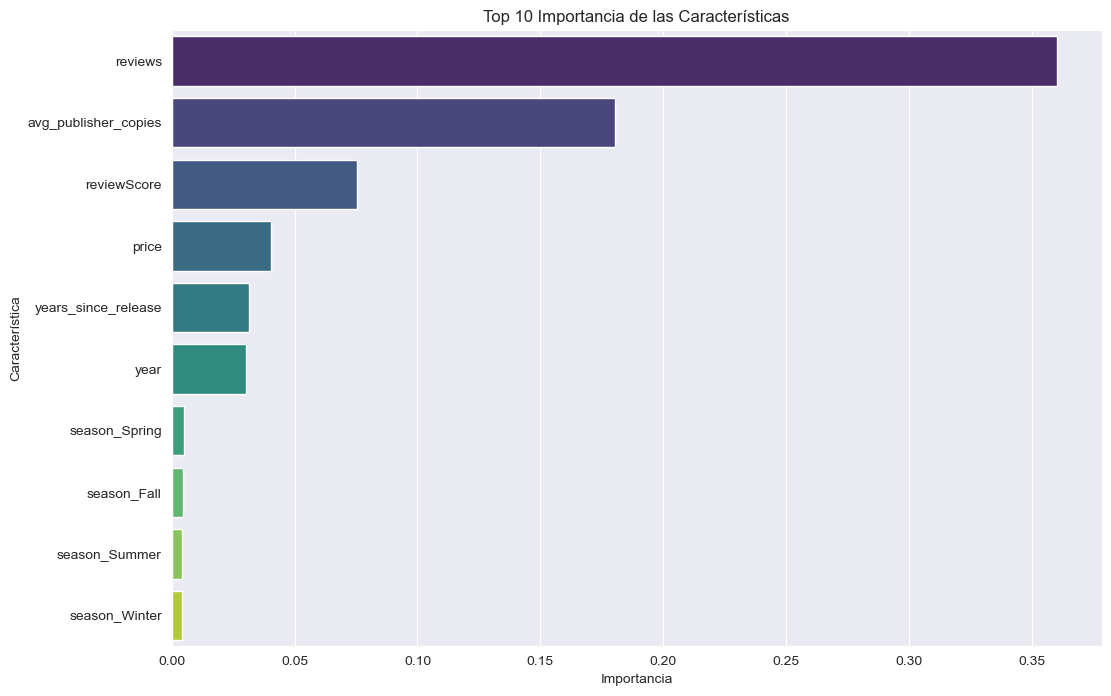

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_sorted, palette='viridis', hue='Feature', dodge=False)
plt.title('Top 10 Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()


In [19]:
import joblib
import pandas as pd

# Se carga el modelo anteriormente entrenado para las clasificaciones de Hits
model_predict = joblib.load('Models/classifier_model_rf.pkl')

# Datos a completar por el desarrollador, que pueden cambiar en el tiempo: reviews, reviewScore, avg_publisher_copies, years_since_release

# Crear un nuevo juego con datos ficticios
new_game = {
    'price': 0, # Siempre es 0 en caso de que un juego sea Free to Play, caso contrario se utilizan generalmente con 99 centimos, por ejemplo: 19.99
    'reviews': 3000,  # Temporal
    'reviewScore': 90,  # Temporal
    'year': 2024,
    'years_since_release': 0,
    'publishers': "PruebaTestTesting",  # Publisher Nuevo a modo de prueba, otros publishers son:
    'avg_publisher_copies': 95000,  # Temporal
    'season': 'Summer',
    'Action': 0,
    'Adventure': 0,
    'Casual': 1,
    'Early Access': 0,
    'Education': 0,
    'Free to Play': 1,
    'Indie': 0,
    'Massively Multiplayer': 0,
    'RPG': 0,
    'Racing': 0,
    'Simulation': 1,
    'Sports': 0,
    'Strategy': 0
}

new_game_df = pd.DataFrame([new_game])

# Se realiza la predicción y se obtienen las probabilidades de que sea un Hit
predicted_hit = model_predict.predict(new_game_df)
predicted_probabilities = model_predict.predict_proba(new_game_df)

print(f"Predicción de hit para el juego nuevo: {predicted_hit[0]}")
print(f"Probabilidad de NO ser un hit (Clase 0): {predicted_probabilities[0][0]:.2f}")
print(f"Probabilidad de ser un hit (Clase 1): {predicted_probabilities[0][1]:.2f}")


Predicción de hit para el juego nuevo: 1
Probabilidad de NO ser un hit (Clase 0): 0.45
Probabilidad de ser un hit (Clase 1): 0.55
